In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import QuantileTransformer
from tqdm import tqdm, trange

from dv_score.util import load_df_dv, load_olfr_info

In [3]:
sns.set_theme(font_scale=1, style="ticks", palette="tab10", context="talk")

# DV score for all OSNs
* Each OSN subtype has a unique DV score

In [4]:
THRESH = 150
df_mature = load_df_dv(filter=True, vc_thresh=THRESH)
uq_mice = df_mature["mouse"].unique()
n_mice = len(uq_mice)
n_olfr = df_mature["top_Olfr"].n_unique()
vc = df_mature["top_Olfr"].value_counts()
print(f"{len(df_mature)} cells from {n_mice} mice")
print(
    f"{n_olfr} OSN subtypes with at least {THRESH} cells (median {vc['count'].median()})"
)

# add percentile normalized DV score
df_mature = df_mature.with_columns(
    DV_qt=QuantileTransformer()
    .fit_transform(df_mature["DV"].to_numpy()[:, None])
    .flatten()
    * 100
)

2283686 cells from 363 mice
1007 OSN subtypes with at least 150 cells (median 1515.0)


In [5]:
df_mature_mean = (
    df_mature.group_by("top_Olfr")
    .agg(pl.col(["DV", "Dorsal", "Ventral", "DV_qt"]).mean())
    .sort("DV")
)
df_mature_median = (
    df_mature.group_by("top_Olfr")
    .agg(pl.col(["DV", "Dorsal", "Ventral", "DV_qt"]).median())
    .sort("DV")
)
n_subtypes = len(df_mature_mean)
xn = np.arange(n_subtypes)

Text(0.5, 1.0, '1007 OSN subtypes')

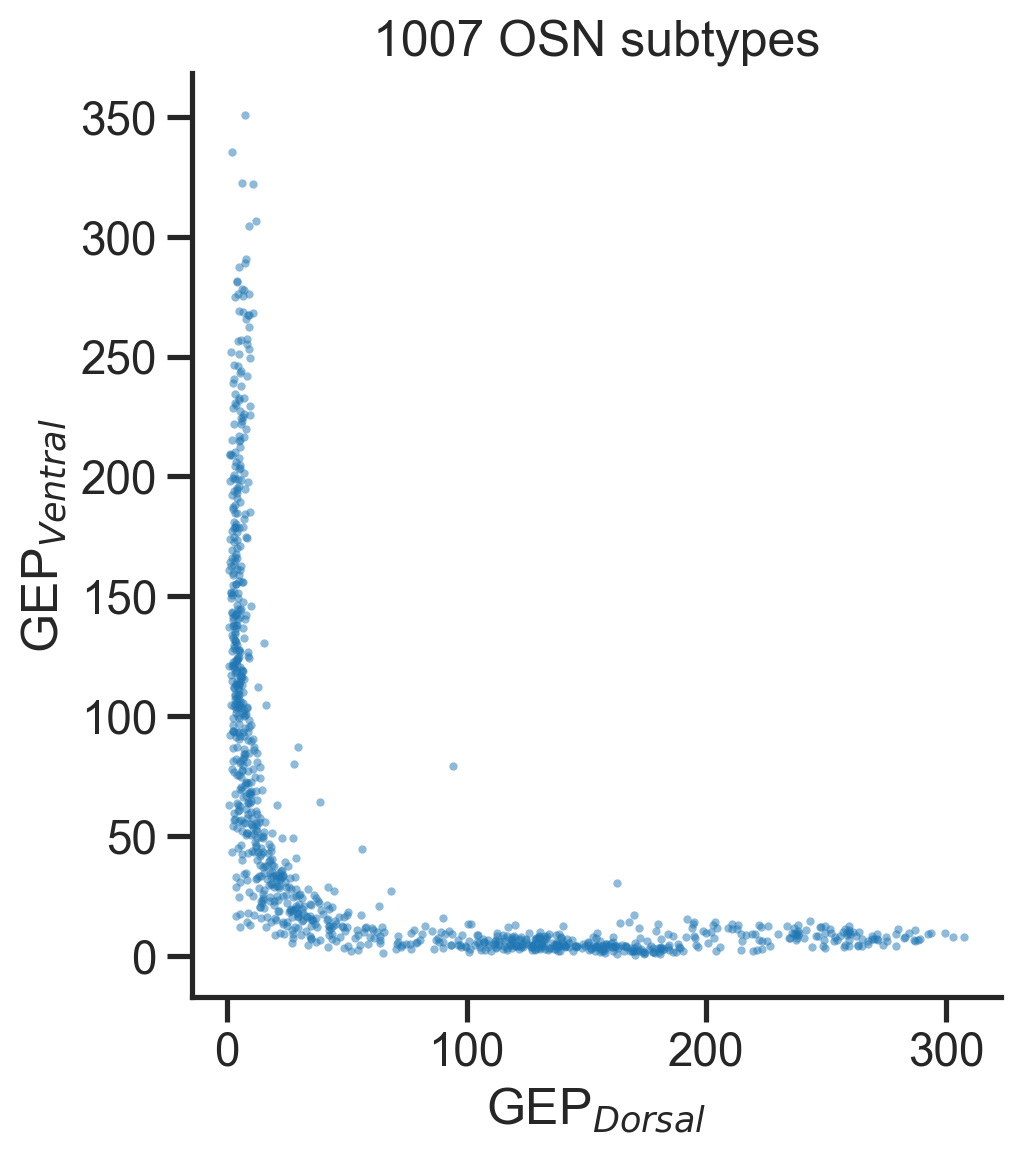

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_mature_mean["Dorsal"], df_mature_mean["Ventral"], alpha=0.5, lw=0, s=9)
sns.despine()
ax.set_xlabel("GEP$_{Dorsal}$")
ax.set_ylabel("GEP$_{Ventral}$")
ax.set_aspect("equal")
ax.set_title(f"{n_subtypes} OSN subtypes")

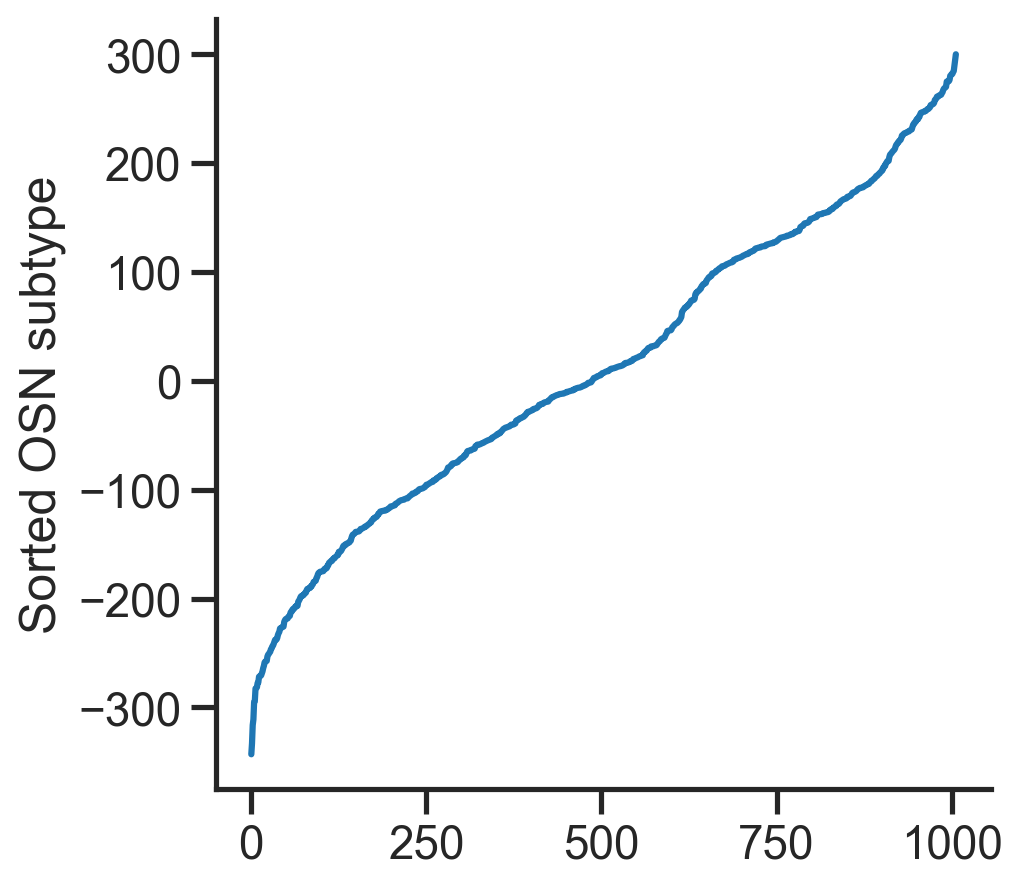

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(xn, df_mature_mean["DV"])
ax.set_ylabel("DV score")
ax.set_ylabel("Sorted OSN subtype")
sns.despine()

Text(0.5, 0, 'DV score')

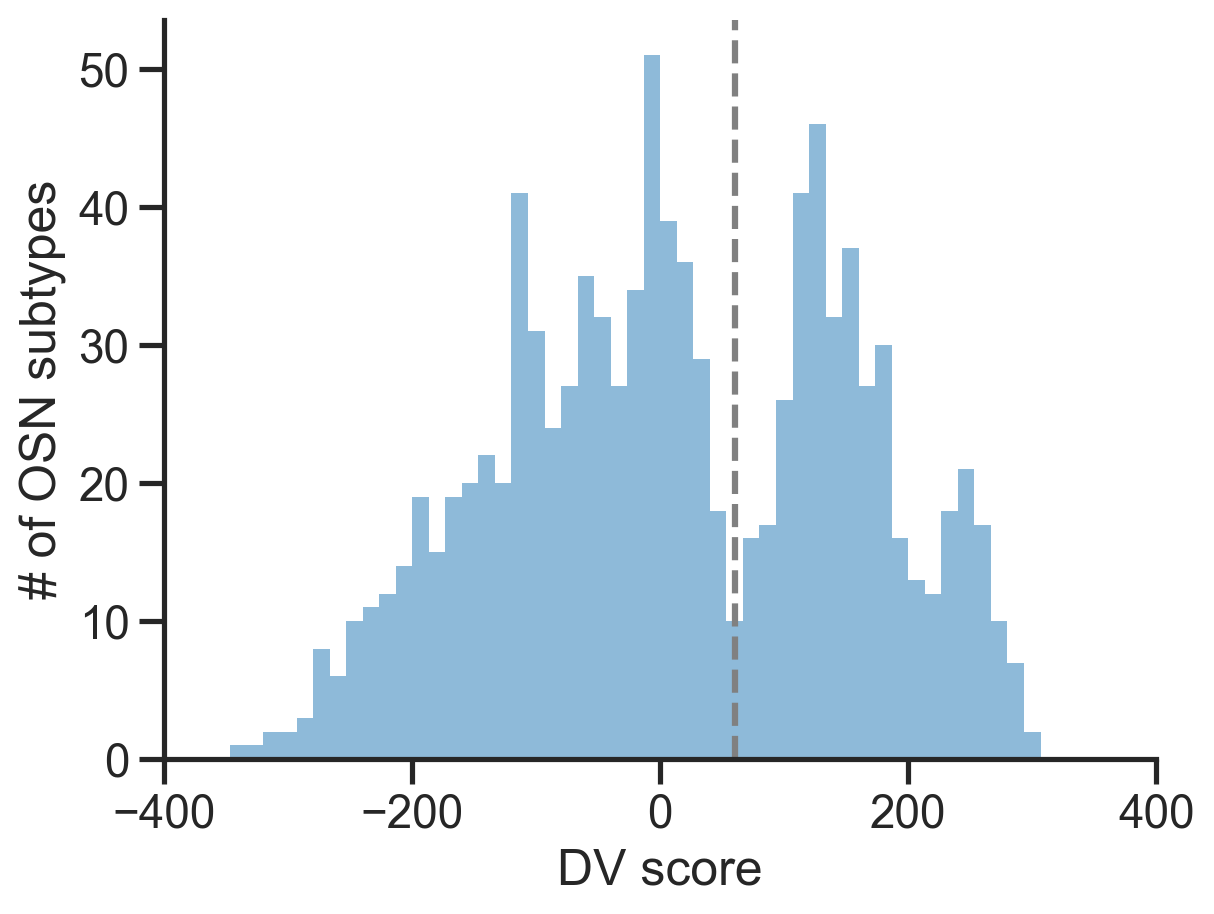

In [8]:
fig, ax = plt.subplots()
bins = np.linspace(-400, 400, 61)
ax.hist(df_mature_mean["DV"], bins=bins, lw=0, alpha=0.5)
ax.set_xlim(-400, 400)
ax.axvline(60, ls="--", color="0.5")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
sns.despine()
ax.set_ylabel("# of OSN subtypes")
ax.set_xlabel("DV score")

In [9]:
# distance from mean on an example restart, sampling equal nubmers of cells per OSN subtype
deltas = (
    df_mature.group_by("top_Olfr")
    .agg(pl.col("DV_qt").sample(THRESH, seed=2025, shuffle=True))
    .select((pl.col("DV_qt") - pl.col("DV_qt").list.mean()))
).explode("DV_qt").to_numpy().flatten()
params = stats.t.fit(deltas)
mad = stats.median_abs_deviation(deltas)
print(f"MAD: {mad:.3f} %")

MAD: 5.615 %


Text(0.5, 0, '∆ DV score percentile (% of all cells)\n from OSN subtype mean')

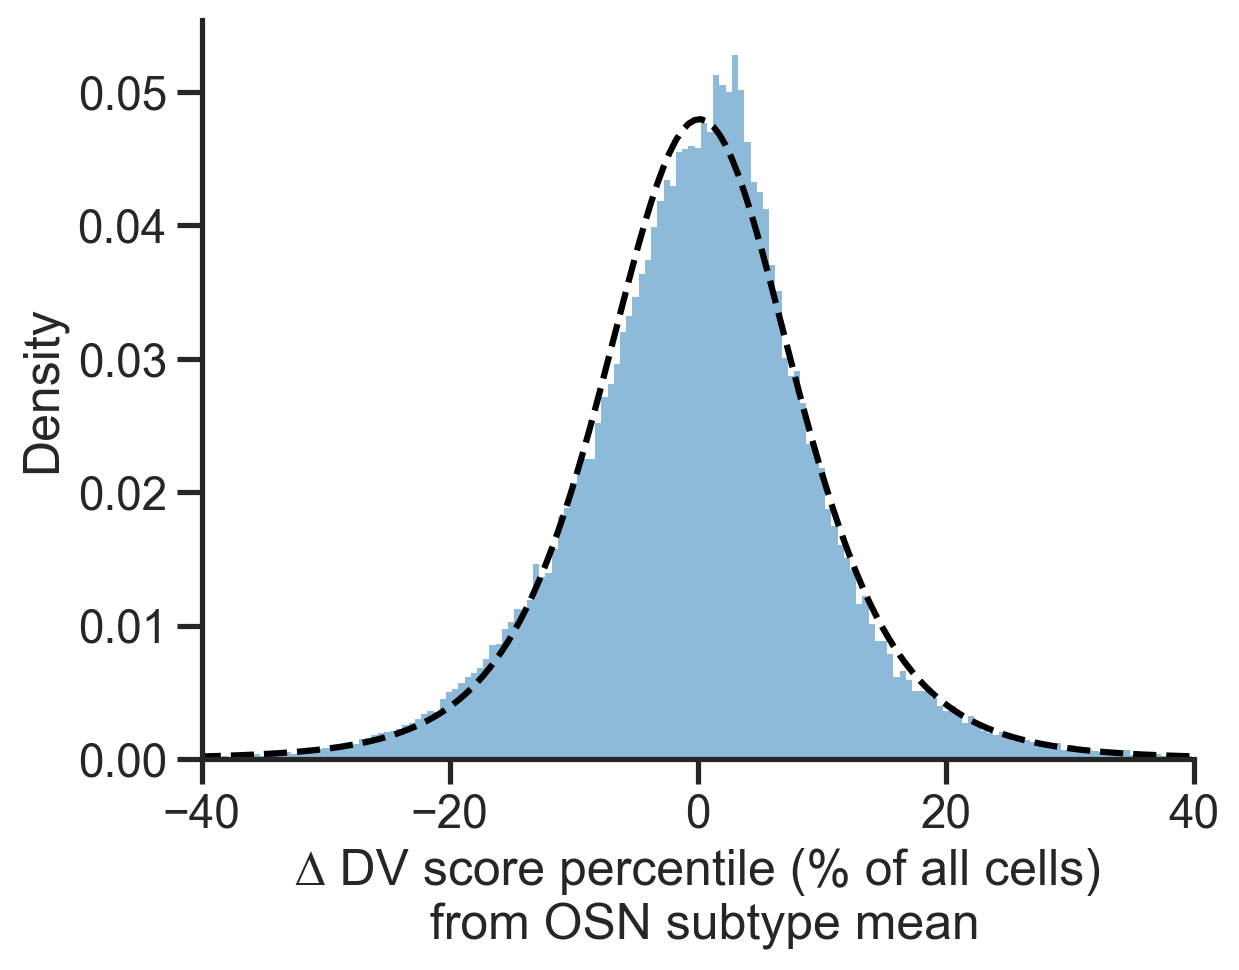

In [10]:
fig, ax = plt.subplots()
rv = stats.t(*params)
bins = np.linspace(-100, 100, 400)

ax.hist(deltas, bins=bins, lw=0, density=True, alpha=0.5)
ax.plot(bins, rv.pdf(bins), ls="--", color="k")
ax.set_xlim(-40, 40)
sns.despine()
ax.set_ylabel("Density")
ax.set_xlabel("∆ DV score percentile (% of all cells)\n from OSN subtype mean")

In [11]:
df_bm = load_olfr_info()
df_mn_class = df_mature_mean.to_pandas().set_index("top_Olfr").join(df_bm.OR_class)
df_mn_class["is_dorsal"] = df_mn_class["DV"] >= 60

Text(0.5, 0, 'OR class')

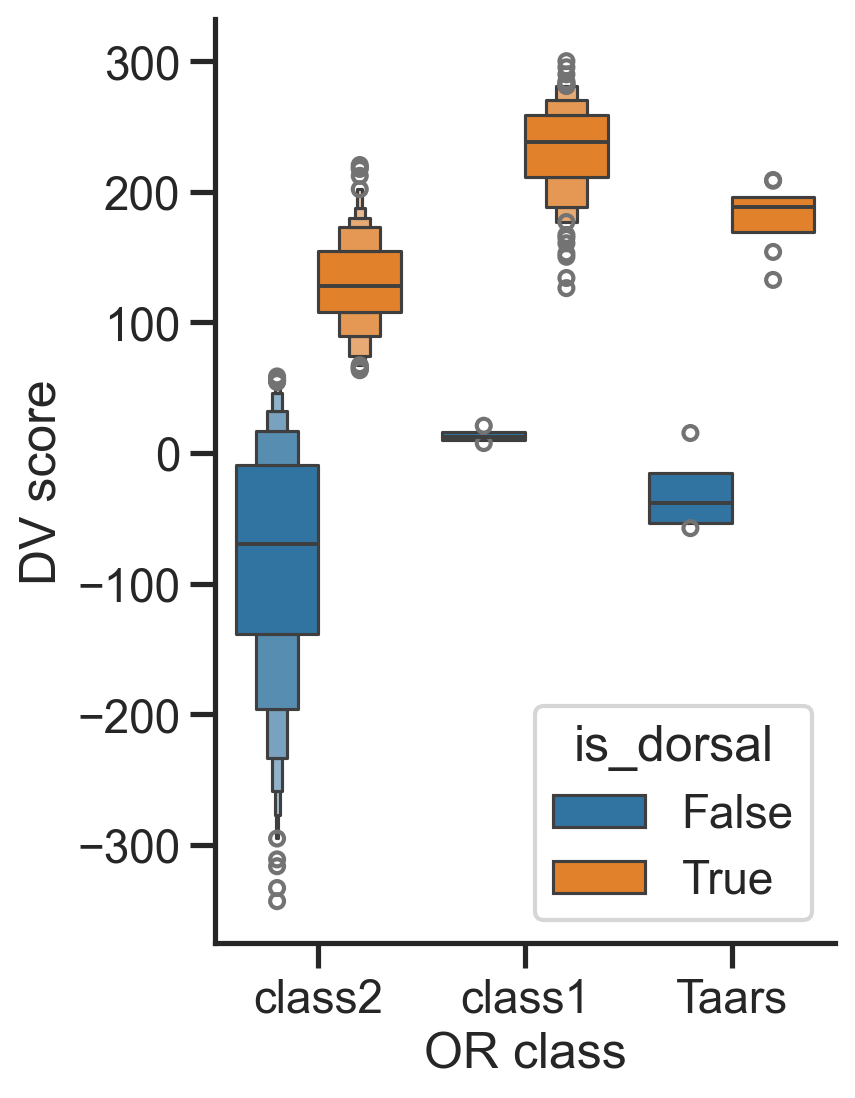

In [12]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.boxenplot(
    data=df_mn_class,
    x="OR_class",
    y="DV",
    hue="is_dorsal",
    order=["class2", "class1", "Taars"],
)
sns.despine()
ax.set_ylabel("DV score")
ax.set_xlabel("OR class")

# Consistency across restarts and replicates

* Since each OSN subtype has a minimum of 150 cells we sample 150 per OR and then divide into two groups and correlate the DV scores
* We can also look at the mean in individual subtypes and compare to all others. Again this is slightly noisier than the whole dataset since individual OSN subtypes in a given mouse can have very few cells and the estimate of the DV score is worse.

In [13]:
def get_stats(d, n=n_olfr):
    corr = d.select(pl.corr("false", "true")).item()
    # median change in ranks
    med_delta = np.median(
        np.abs(np.diff(stats.rankdata(d[["false", "true"]], axis=0), axis=1))
    )
    return corr, med_delta / n

In [14]:
THRESH_HALF = THRESH // 2
n_rep = 100
obs_mat = np.zeros((n_rep, 2))
shuff_mat = np.zeros_like(obs_mat)
is_first = np.tile(np.arange(THRESH) < THRESH_HALF, n_olfr)
for i in trange(n_rep, ncols=80):
    df_obs = (
        df_mature.group_by("top_Olfr")
        .agg(pl.col("DV").sample(THRESH, with_replacement=False))
        .explode("DV")
    )
    df_subsample = (
        df_obs.with_columns(bin=is_first)
        .group_by(["top_Olfr", "bin"])
        .mean()
        .pivot(index="top_Olfr", on="bin", values="DV")
        .sort("top_Olfr")
    )
    obs_mat[i] = get_stats(df_subsample)
    df_shuffle = (
        df_obs.with_columns(pl.col("top_Olfr").shuffle())
        .sort("top_Olfr")
        .with_columns(bin=is_first)
        .group_by(["top_Olfr", "bin"])
        .mean()
        .pivot(index="top_Olfr", on="bin", values="DV")
        .sort("top_Olfr")
    )
    shuff_mat[i] = get_stats(df_shuffle)

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.54it/s]


In [15]:
print(obs_mat.mean(0))
print(shuff_mat.mean(0))

[0.99766518 0.01147964]
[-0.00838284  0.29402185]


In [16]:
df_both = pd.concat(
    {
        "obs": pd.DataFrame(obs_mat, columns=["corr", "rank"]),
        "shuffled": pd.DataFrame(shuff_mat, columns=["corr", "rank"]),
    }
).reset_index()

Text(0.5, 0, '')

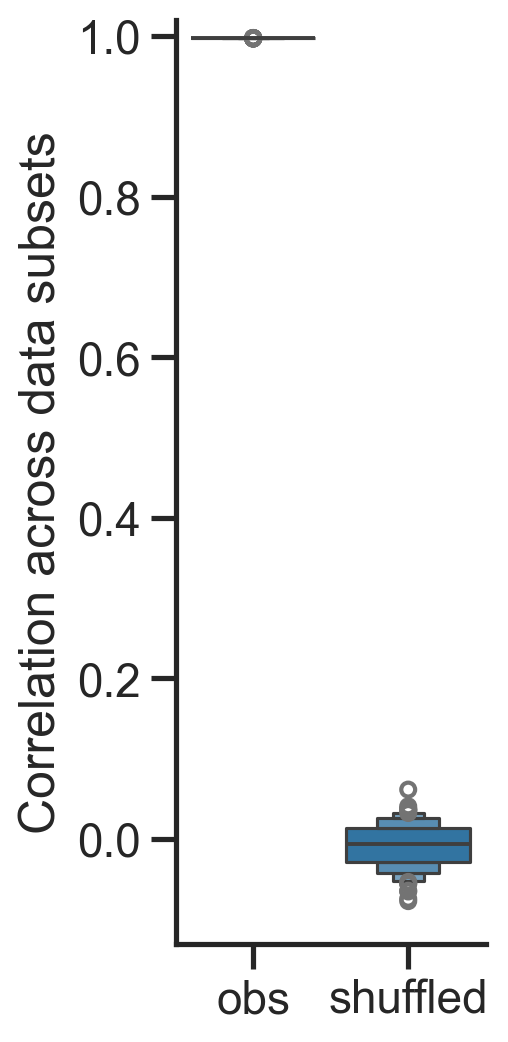

In [17]:
fig, ax = plt.subplots(figsize=(2, 6))
sns.boxenplot(data=df_both, x="level_0", y="corr")
sns.despine()
ax.set_ylabel("Correlation across data subsets")
ax.set_ylim(None, 1.02)
ax.set_xlabel(None)

In [18]:
# compre each replicate to all others
corr_results = np.zeros(n_mice)
for i, m in enumerate(tqdm(uq_mice, ncols=80)):
    df_test = df_mature.with_columns(is_mouse=pl.col("mouse") == m)
    olfr_use = (
        df_test.filter(pl.col("is_mouse"))
        .group_by(["top_Olfr"])
        .len()
        .filter(pl.col("len") >= 4)
        .select(pl.col("top_Olfr"))
    )
    # join to keep only ORs with at least 4 cells in test mouse
    # compare correlation to mean from all other mice
    corr_results[i] = (
        df_test.group_by(["top_Olfr", "is_mouse"])
        .agg(pl.col("DV").mean())
        .join(olfr_use, on="top_Olfr", how="inner")
        .pivot(on="is_mouse", index="top_Olfr", values="DV")
        .select(pl.corr("true", "false", propagate_nans=False, method="spearman"))
        .item()
    )

100%|█████████████████████████████████████████| 363/363 [00:17<00:00, 21.08it/s]


Text(0, 0.5, '# of replicates')

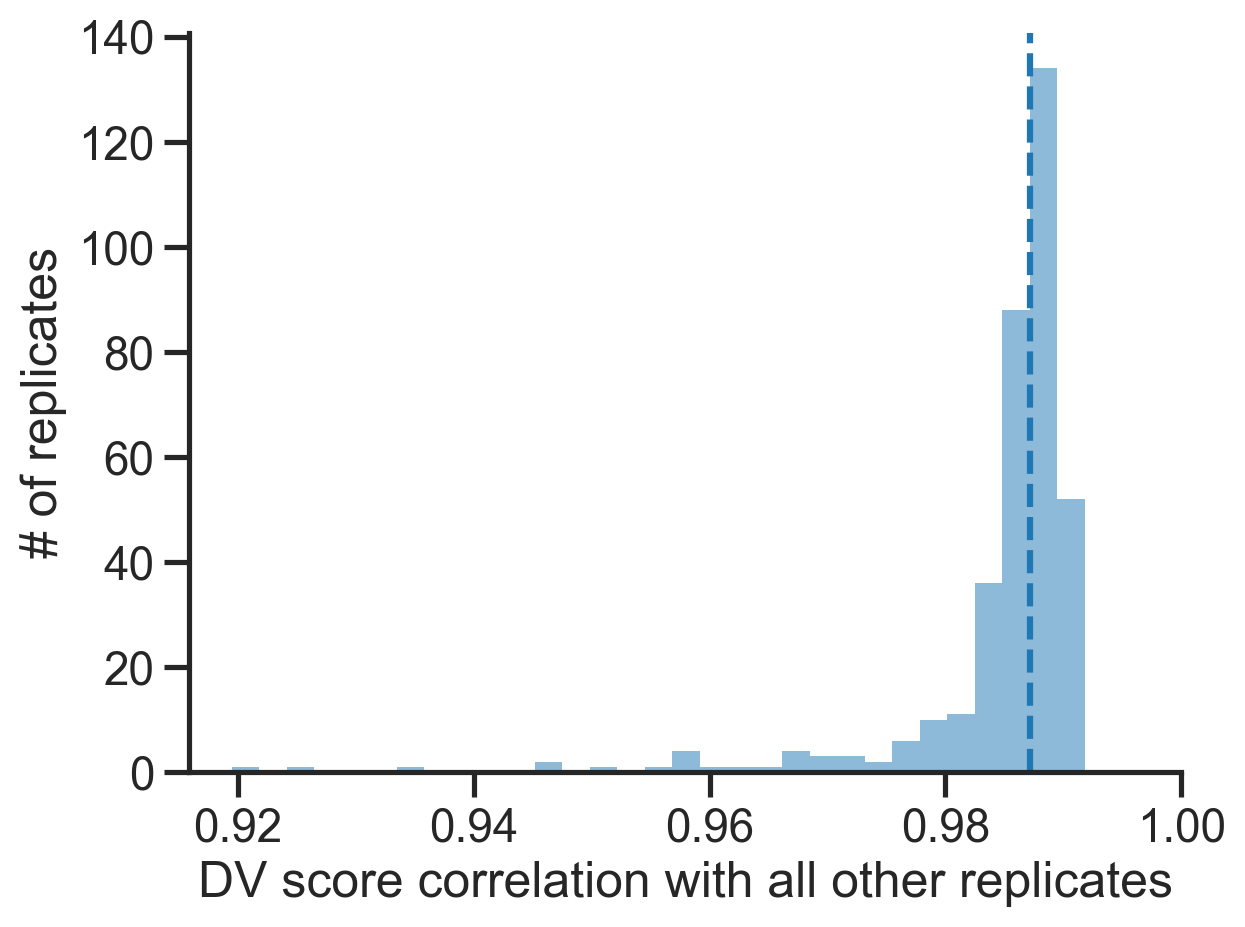

In [19]:
fig, ax = plt.subplots()
plt.hist(corr_results, bins=31, lw=0, alpha=0.5);
ax.axvline(np.median(corr_results), ls="--")
ax.set_xlim(None, 1)
sns.despine()
ax.set_xlabel("DV score correlation with all other replicates")
ax.set_ylabel("# of replicates")